## This is a toy model of the climate system and it's response to geoengineering

#### Ali Duffey, 27/10/2021

# to do:


In [10]:
### import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#### The cell below contains editable scalar inputs which define the model run

In [11]:
### user controls

#define physical scalars
Transient_Climate_Sensitivity_degrees = 2
Current_Emissions_GtCO2 = 40
Current_Atmospheric_CO2_Conc = 415
Pre_Ind_CO2_ppm = 280
Current_Transient_Warming_Above_Preind_degrees = 1.2
GtCO2_Per_Doubling_Pre_Industrial = 2400
Fraction_CO2_Emissions_Remaining_In_Atmos = 0.4

#define model run parameters
Start_Year = 2021
End_Year = 2250

#define emissions scenario
Emissions_Peak_Year = 2025
Emissions_Reduction_Year = 2030
Emissions_Growth_Rate_Prior_To_Peak = 0.01
Emissions_Annual_Reduction_Fraction = 0.015
Negative_Emissions_Start_year = 2030
Negative_Emissions_Scale_Up_years = 30
Negative_Emissions_Cap_GtCO2 = -10

#### Scenario 1: No geoengineering 
The following three cells set up the model workings for the CO2 emissions trajectory and climate response, and plot the results

In [12]:
### model set up

#define annual variables dataframe to fill
years = np.arange(Start_Year, End_Year)
annual_variables = pd.DataFrame(data=years,  columns=["Year"])

#define emissions trajectory - exponential growth, followed by plateau, then exponential decrease
annual_variables['Emissions_GtCO2'] = 0.00
annual_variables.loc[annual_variables['Year'] == Start_Year, 'Emissions_GtCO2'] = Current_Emissions_GtCO2
annual_variables.loc[(annual_variables['Year'] > Start_Year) & (annual_variables['Year'] <= Emissions_Peak_Year),
                     'Emissions_GtCO2'] = Current_Emissions_GtCO2*((1+Emissions_Growth_Rate_Prior_To_Peak)**(annual_variables['Year']-Start_Year))
annual_variables.loc[(annual_variables['Year'] > Emissions_Peak_Year) & (annual_variables['Year'] < Emissions_Reduction_Year),
                     'Emissions_GtCO2'] = Current_Emissions_GtCO2*((1+Emissions_Growth_Rate_Prior_To_Peak)**(Emissions_Peak_Year-Start_Year))
peak_emissions = annual_variables['Emissions_GtCO2'].max()
annual_variables.loc[annual_variables['Year'] >= Emissions_Reduction_Year, 'Emissions_GtCO2'] = peak_emissions*(
    (1-Emissions_Annual_Reduction_Fraction)**(annual_variables['Year']-Emissions_Reduction_Year))

#define conversion from emissions CO2 to atmospheric concentration
ppm_atmos_CO2_per_GtCO2_in_atmos = 1/7.8
ppm_atmos_CO2_per_GtCO2_emissions = Fraction_CO2_Emissions_Remaining_In_Atmos*ppm_atmos_CO2_per_GtCO2_in_atmos

#define annual atmospheric CO2 concentration
annual_variables['atmospheric_CO2_ppm'] = 0.00
annual_variables['atmospheric_CO2_ppm'] = Current_Atmospheric_CO2_Conc + ppm_atmos_CO2_per_GtCO2_emissions*annual_variables['Emissions_GtCO2'].cumsum()
annual_variables['atmospheric_CO2_ppm_above_preind'] = annual_variables['atmospheric_CO2_ppm'] - Pre_Ind_CO2_ppm



C:\Users\alist\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


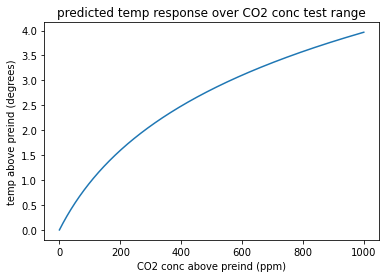

In [13]:
### define function to fit a log curve to two temp vs CO2 conc data points 

# the two data points used are warming to date (user defined) and the transient climate sensitivy (also user defined)
# using only two data points, both with significant ppm above preind means the function is not well behaved as..
#.. the co2 concentration above pre industrial goes to zero. 

CO2_ppm_data = [0, Current_Atmospheric_CO2_Conc-Pre_Ind_CO2_ppm, Pre_Ind_CO2_ppm*2-Pre_Ind_CO2_ppm]
Temp_data = [0, Current_Transient_Warming_Above_Preind_degrees, Transient_Climate_Sensitivity_degrees]

def func(x, a, b, c):
    return a + b*np.log(x+c)

popt, pcov = curve_fit(func, CO2_ppm_data, Temp_data)

test_atmos_CO2_range = np.arange(0, 1000)
plt.plot(test_atmos_CO2_range, func(test_atmos_CO2_range, *popt))
plt.title('predicted temp response over CO2 conc test range')
plt.xlabel('CO2 conc above preind (ppm)')
plt.ylabel('temp above preind (degrees)')

#define temperature response to atmospheric CO2 concentration
annual_variables['temp_above_preind'] =  func(annual_variables['atmospheric_CO2_ppm_above_preind'], *popt)

Text(0.5, 1.0, 'temp (GMST, degrees)')

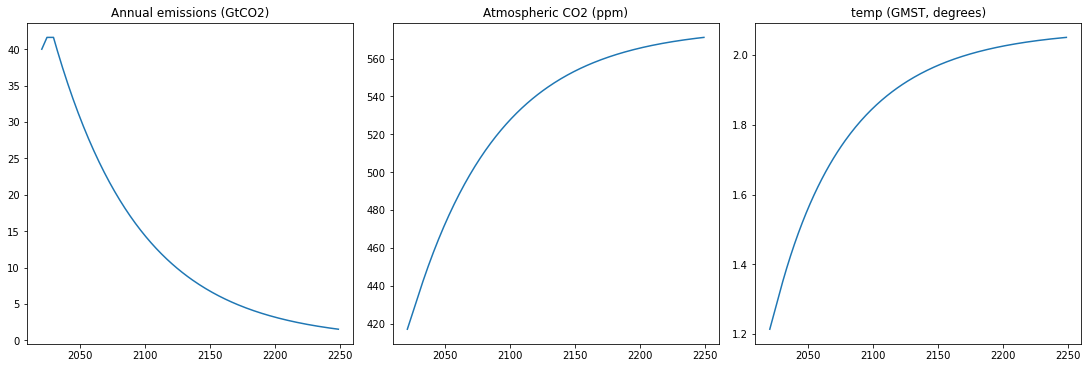

In [14]:
# plot CO2 emissions and climate response

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))
#fig.suptitle('Horizontally stacked subplots')
ax1.plot(annual_variables['Year'], annual_variables['Emissions_GtCO2'])
ax1.set_title('Annual emissions (GtCO2)')
ax2.plot(annual_variables['Year'], annual_variables['atmospheric_CO2_ppm'])
ax2.set_title('Atmospheric CO2 (ppm)')
ax3.plot(annual_variables['Year'], annual_variables['temp_above_preind'])
ax3.set_title('temp (GMST, degrees)')


#### Scenario 2: carbon dioxide removal (CDR) only
We now add CDR and repeat. The cell below contains user inputs related to CDR, followed by model set-up and results

In [15]:
# user inputs
Negative_Emissions_Start_Year = 2030
Negative_Emissions_Growth_Rate_GtCO2_per_Year = 0.2
Negative_Emissions_Cap_GtCO2 = 15

Text(0.5, 1.0, 'temp (GMST, degrees)')

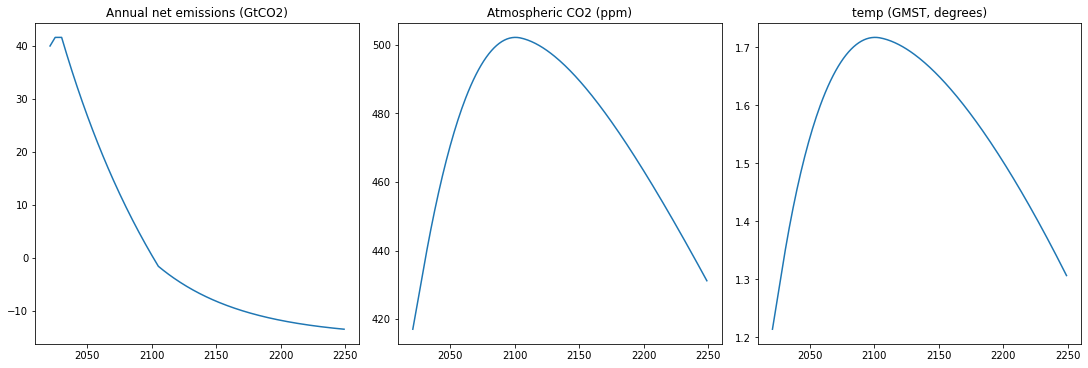

In [16]:
# model set up - recreate DF with negative emissions
annual_variables_CDR = annual_variables[["Year", "Emissions_GtCO2"]].copy()
annual_variables_CDR["negative_emissions_GtCO2"] = (annual_variables_CDR["Year"] - Negative_Emissions_Start_Year) * Negative_Emissions_Growth_Rate_GtCO2_per_Year
annual_variables_CDR["negative_emissions_GtCO2"] = annual_variables_CDR["negative_emissions_GtCO2"].clip(0, Negative_Emissions_Cap_GtCO2)
annual_variables_CDR["net_emissions_GtCO2"] = annual_variables_CDR["Emissions_GtCO2"] - annual_variables_CDR["negative_emissions_GtCO2"]

#define resulting annual atmospheric CO2 concentration
annual_variables_CDR['atmospheric_CO2_ppm'] = 0.00
annual_variables_CDR['atmospheric_CO2_ppm'] = Current_Atmospheric_CO2_Conc + ppm_atmos_CO2_per_GtCO2_emissions*annual_variables_CDR['net_emissions_GtCO2'].cumsum()
annual_variables_CDR['atmospheric_CO2_ppm_above_preind'] = annual_variables_CDR['atmospheric_CO2_ppm'] - Pre_Ind_CO2_ppm

#calculate resulting temp
annual_variables_CDR['temp_above_preind'] =  func(annual_variables_CDR['atmospheric_CO2_ppm_above_preind'], *popt)

# re-plot CO2 emissions and climate response, this time with CDR
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))
ax1.plot(annual_variables_CDR['Year'], annual_variables_CDR['net_emissions_GtCO2'])
ax1.set_title('Annual net emissions (GtCO2)')
ax2.plot(annual_variables_CDR['Year'], annual_variables_CDR['atmospheric_CO2_ppm'])
ax2.set_title('Atmospheric CO2 (ppm)')
ax3.plot(annual_variables_CDR['Year'], annual_variables_CDR['temp_above_preind'])
ax3.set_title('temp (GMST, degrees)')

#### Scenario 3: CDR and solar geoengineering
Finally, we add a solar geoengineering scenario to the mix. The inputs in the cell below define this scenario. We assume strasopheric aerosol injection is used to cap warming at a particular value (e.g. 2 degrees), then derive information about the geoengineering timescale and injection mass implied by such a cap.

In [21]:
#user inputs
SAI_warming_cap_degrees = 1.5



Text(2150, 1.3, 'SAI length :155')

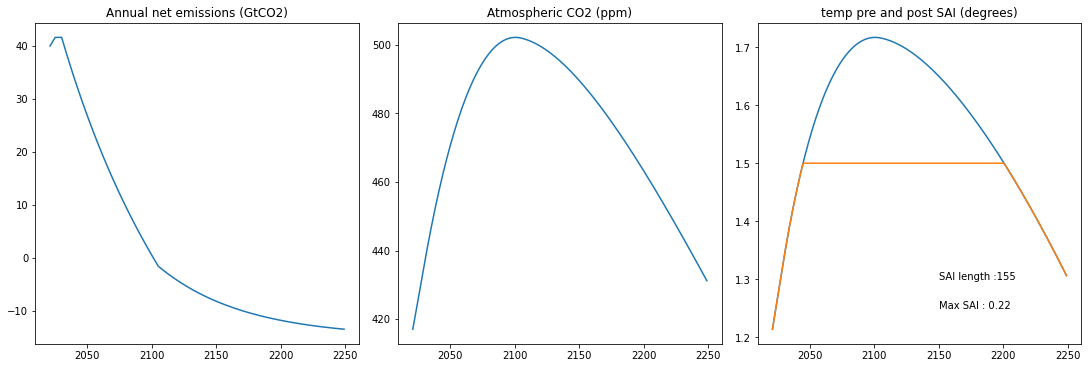

In [32]:
#model set-up 
annual_variables_SAI = annual_variables_CDR.copy()
annual_variables_SAI["SAI_temp_degrees"] = annual_variables_CDR['temp_above_preind'].clip(
    upper=SAI_warming_cap_degrees)
annual_variables_SAI["SAI_temp_difference"] =  annual_variables_CDR['temp_above_preind'] - annual_variables_SAI["SAI_temp_degrees"] 
SAI_start_year = annual_variables_SAI["Year"].loc[annual_variables_SAI["SAI_temp_difference"] > 0].min()
SAI_end_year = annual_variables_SAI["Year"].loc[annual_variables_SAI["SAI_temp_difference"] > 0].max()
SAI_length = SAI_end_year - SAI_start_year
SAI_max_temp_diff = annual_variables_SAI["SAI_temp_difference"].max()

# re-plot CO2 emissions and climate response, this time with CDR and SAI
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))
ax1.plot(annual_variables_SAI['Year'], annual_variables_SAI['net_emissions_GtCO2'])
ax1.set_title('Annual net emissions (GtCO2)')
ax2.plot(annual_variables_SAI['Year'], annual_variables_SAI['atmospheric_CO2_ppm'])
ax2.set_title('Atmospheric CO2 (ppm)')
ax3.plot(annual_variables_SAI['Year'], annual_variables_SAI['temp_above_preind'])
ax3.plot(annual_variables_SAI['Year'], annual_variables_SAI["SAI_temp_degrees"])
ax3.set_title('temp pre and post SAI (degrees)') 
ax3.text(End_Year-100, Current_Transient_Warming_Above_Preind_degrees+0.05, "Max SAI : " + str(np.round(SAI_max_temp_diff, 2)))
ax3.text(End_Year-100, Current_Transient_Warming_Above_Preind_degrees+0.1, "SAI length :" + str(SAI_length))
